In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
import torch
import os
import glob
import matplotlib.pyplot as plt

from pathlib import PurePath
from sklearn import metrics as skmetrics
from sklearn import dummy as skdummy
from IPython import display

import vxs
import vxs.utils as vxsu

/usr/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning:

can't resolve package from __spec__ or __package__, falling back on __name__ and __path__



In [2]:
avp_set = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/')

In [3]:
def compare_fixed_personal(name):
    fixed = name + '_Fixed'
    personal = name + '_Personal'
    for x in [fixed, personal]:
        track, anno = avp_set.get(x)
        vxsu.display_track(track)

../data/avp-dataset/AVP_Dataset/Fixed/Participant_5/P5_HHclosed_Fixed.wav


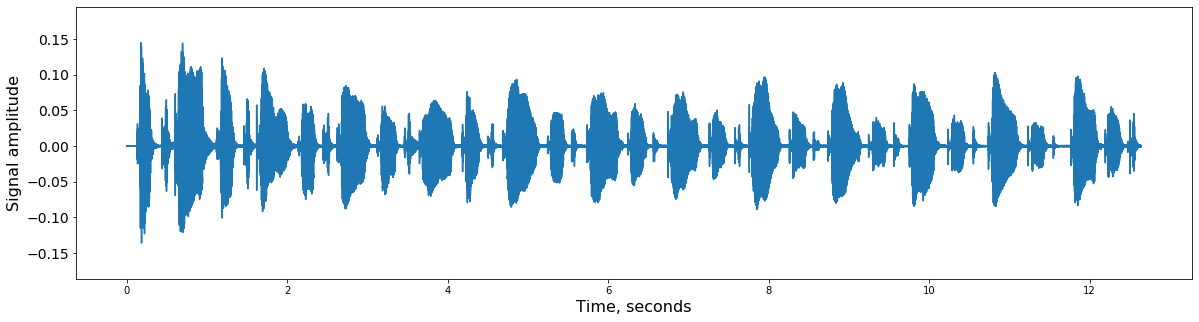

/home/flyingleafe/vxs-vpt/pythonenv/lib/python3.6/site-packages/IPython/lib/display.py:173: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



../data/avp-dataset/AVP_Dataset/Personal/Participant_5/P5_HHclosed_Personal.wav


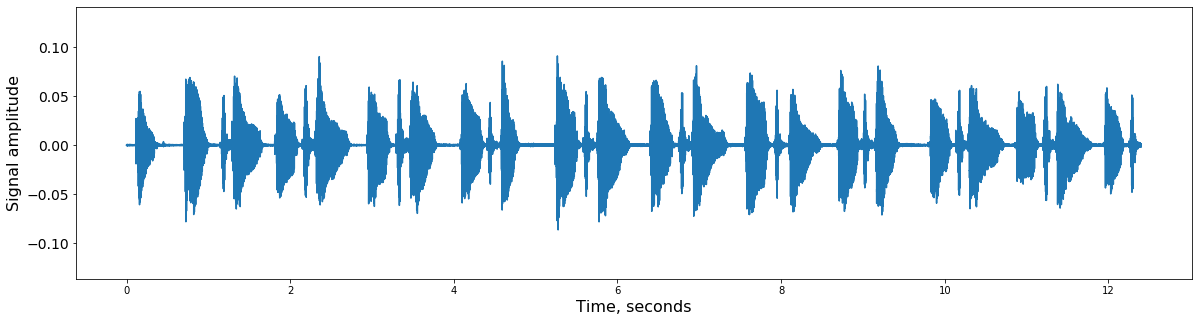

/home/flyingleafe/vxs-vpt/pythonenv/lib/python3.6/site-packages/IPython/lib/display.py:173: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



In [4]:
compare_fixed_personal('P5_HHclosed')

### Generated stuff

In [5]:
gen_set = vxs.GenTrackSet('../data_temp/avp-gen/')
len(gen_set)

50

../data_temp/avp-gen/avp_p5_fixed_8.wav


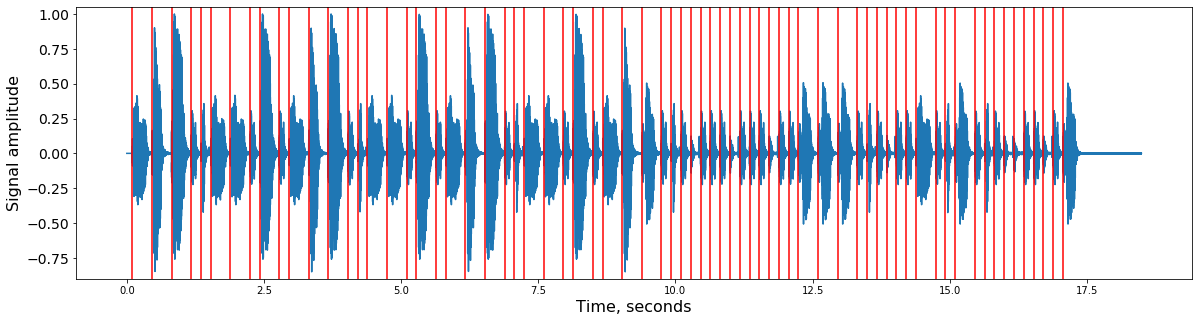

/home/flyingleafe/vxs-vpt/pythonenv/lib/python3.6/site-packages/IPython/lib/display.py:173: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



In [32]:
track, anno = gen_set.get(0)
vxsu.display_track(track, anno)

In [10]:
titles_map_metric = {
    'prec': 'Precision',
    'rec': 'Recall',
    'F1': 'F1'
}

titles_map_classes = {
    'kd': 'Kick',
    'sd': 'Snare',
    'hhc': 'HHClosed',
    'hho': 'HHOpened',
    'total': 'Total'
}

def plot_metrics(series_lm, series_nolm, metric, cl,
                 title=None, xlabel=None, ylabel=None, ax=None,
                 ylims=None, noonsets=False, fsize=14):
    if ax is not None:
        plt.sca(ax)
    xs = np.arange(len(series_nolm['keys']))
    xticks = series_nolm['keys']
    plt.plot(xs, series_nolm[metric][cl],
             label='No LM'+(' (true onsets)' if noonsets else ''),
             linestyle=('--' if noonsets else '-'), color='tab:blue')
    plt.plot(xs, series_lm[metric][cl],
             label='LM'+(' (true onsets)' if noonsets else ''),
             linestyle=('--' if noonsets else '-'), color='tab:orange')
    plt.xticks(ticks=xs, labels=xticks, fontsize=fsize-4)
    
#     yticks_min = min(np.min(series_nolm[metric][cl]), np.min(series_lm[metric][cl]))
#     yticks_max = max(np.max(series_nolm[metric][cl]), np.max(series_lm[metric][cl]))
#     yticks = np.linspace(yticks_min-0.005, yticks_max+0.005, 5)
#     yticks_labels = [np.format_float_positional(t, precision=2) for t in yticks]
    plt.yticks(fontsize=fsize-4)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=fsize)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=fsize)
    if ylims is not None:
        plt.ylim(ylims)
    if title is not None:
        plt.title(title, fontsize=fsize)
    
def plot_all_metrics(series_lm, series_nolm, series_noonsets_lm=None,
                     series_noonsets_nolm=None, ylims=None, save_name=None,
                     fsize=16, fsize_mul=(2.3, 1.6)):
    classes = ['kd', 'sd', 'hhc', 'hho', 'total']
    metrics = ['prec', 'rec', 'F1']

    rows = len(classes)
    cols = len(metrics)
#     rows = len(metrics)
#     cols = len(classes)
    fig, axes = plt.subplots(ncols=cols, nrows=rows,
                             figsize=(cols*fsize_mul[0], rows*fsize_mul[1]),
                             sharex=True, sharey=False)
    
    for cl_ix, axes_ in enumerate(axes):
        for m_ix, ax in enumerate(axes_):
    #for m_ix, axes_ in enumerate(axes):
    #    for cl_ix, ax in enumerate(axes_):
            cl = classes[cl_ix]
            mc = metrics[m_ix]
            
            title = titles_map_metric[mc] if cl_ix == 0 else None
            ylabel = cl if m_ix == 0 else None
            xlabel = '$k$' if cl_ix == len(classes) - 1 else None
    
#             title = titles_map_classes[cl] if m_ix == 0 else None
#             ylabel = titles_map_metric[mc] if cl_ix == 0 else None
#             xlabel = '$k$' if m_ix == len(metrics) - 1 else None
    
            if series_noonsets_lm is not None and series_noonsets_nolm is not None:
                plot_metrics(series_noonsets_lm, series_noonsets_nolm, mc, cl, 
                             ax=ax, noonsets=True, fsize=fsize)
            
            plot_metrics(series_lm, series_nolm, mc, cl,
                         ax=ax, ylims=ylims, title=title, xlabel=xlabel,
                         ylabel=ylabel, fsize=fsize)
            
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            plt.grid(which='both')
    
    fig.tight_layout()

#     cols = 4 if series_noonsets_lm is not None else 2
#     axes[-1][2].legend(loc='lower center', ncol=cols,
#                        fontsize=fsize-2, bbox_to_anchor=(0.5, -1.1)) 
    axes[2][-1].legend(loc='upper left', fontsize=fsize-2, bbox_to_anchor=(1.05, 1))
    
    if save_name is not None:
        vxsu.save_plot(save_name)
    plt.show()

In [11]:
def evaluate_with_different_k(eval_set, knn, lang_model, savedir_pattern,
                              ks=[3 ,5, 7, 10, 15], random_seed=42,
                              reuse_saved=True, verbose=True, **kwargs):
    evaluation_cfs = {}
    for k in ks:
        savedir = savedir_pattern.format(k)
        evaluation_cfs[k] = {}
        knn.set_params(classifier__n_neighbors=k)
        
        if verbose:
            print(f'k-NN with k = {k}')
            print('Evaluating (no LM)')
            
        nolm_cf, nolm_scores = vxs.segment_classify_all(eval_set, knn, save_dir=savedir+'/nolm',
                                                        reuse_saved=reuse_saved, **kwargs)
        evaluation_cfs[k]['nolm'] = nolm_cf

        if verbose:
            display.display(nolm_scores)
            print('Evaluating (LM)')

        lm_cf, lm_scores = vxs.segment_classify_all(eval_set, knn, lang_model, save_dir=savedir+'/lm',
                                                    reuse_saved=reuse_saved, **kwargs)
        evaluation_cfs[k]['lm'] = lm_cf

        if verbose:
            display.display(lm_scores)
            
    return evaluation_cfs

In [34]:
paths = glob.glob('../data_temp/avp-cut/fixed/*/*.wav')
excluded_ps = [f'participant_{n}' for n in range(1, 6)]
paths = [p for p in paths if PurePath(p).parts[-2] not in excluded_ps]

avp_segments_fixed_p6_28 = vxs.SimpleSampleSet(paths)
len(avp_segments_fixed_p6_28)

2766

In [23]:
lang_model = vxs.load_model_from_bundle('../data/drum_kit_rnn.mag')

'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from /tmp/tmpuucghfos/model_drum_kit.ckpt


/home/flyingleafe/vxs-vpt/pythonenv/lib/python3.6/site-packages/tensorflow/python/framework/tensor_util.py:523: DeprecationWarning:

tostring() is deprecated. Use tobytes() instead.



In [35]:
mfcc_classifier = vxs.make_knn_classic('mfcc', n_neighbors=10, weights='distance')
X, y = vxsu.unzip_dataset(avp_segments_fixed_p6_28)
mfcc_classifier.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransform(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=10, weights='distance'))])

In [27]:
%%time
evaluation_cfs = evaluate_with_different_k(
    gen_set, mfcc_classifier, lang_model, reuse_saved=False,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avpfixed_k{}',
    predefined_bpm=True)

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 50it [00:46,  1.08it/s]


prec       rec        F1
hhc    0.897683  0.883191  0.890378
hho    0.596117  0.916418  0.722353
kd     0.976546  0.607427  0.748978
sd     0.841304         1  0.913813
total  0.839516   0.82325  0.831304

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:33,  1.88s/it]


prec       rec        F1
hhc    0.936145  0.737892  0.825279
hho    0.594262  0.865672  0.704739
kd     0.962175  0.539788  0.691589
sd     0.722114  0.953488  0.821826
total  0.818384  0.728747  0.770968

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 50it [00:47,  1.06it/s]


prec       rec        F1
hhc    0.890547  0.849953  0.869776
hho    0.573832  0.916418  0.705747
kd      0.97619  0.598143  0.741776
sd     0.809623         1  0.894798
total  0.822581  0.806643  0.814534

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:45,  2.12s/it]


prec       rec        F1
hhc    0.972441  0.703704  0.816529
hho    0.529617  0.907463  0.668867
kd     0.946262  0.537135  0.685279
sd     0.760246  0.958656     0.848
total  0.808615  0.720047  0.761765

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 50it [00:47,  1.06it/s]


prec       rec        F1
hhc    0.913361  0.830959  0.870214
hho    0.545293  0.916418  0.683742
kd     0.975877  0.590186  0.735537
sd     0.769384         1  0.869663
total  0.812097  0.796362  0.804153

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:55,  2.30s/it]


prec       rec        F1
hhc     0.98209  0.624881  0.763784
hho    0.492707  0.907463  0.638655
kd     0.969267  0.543767  0.696686
sd     0.684502  0.958656  0.798708
total  0.773979  0.689205  0.729136

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 50it [00:47,  1.04it/s]


prec       rec        F1
hhc    0.909664  0.822412   0.86384
hho    0.567325  0.943284   0.70852
kd     0.973742  0.590186   0.73493
sd     0.752918         1  0.859046
total  0.812097  0.796362  0.804153

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:59,  2.38s/it]


prec       rec        F1
hhc    0.984563  0.545109  0.701711
hho    0.436963  0.910448  0.590513
kd      0.96368  0.527851  0.682091
sd      0.66129  0.953488  0.780952
total  0.730906   0.65085  0.688559

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 50it [00:48,  1.04it/s]


prec       rec        F1
hhc    0.930286  0.773029  0.844398
hho    0.532773  0.946269   0.68172
kd     0.971223  0.537135  0.691716
sd     0.642496  0.984496  0.777551
total  0.772984  0.758007  0.765422

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [02:13,  2.67s/it]


prec       rec        F1
hhc    0.987273   0.51567   0.67748
hho    0.414169  0.907463  0.568756
kd     0.943529   0.53183  0.680237
sd     0.664825  0.932817  0.776344
total  0.714476   0.63622  0.673081

CPU times: user 21min 53s, sys: 8min 25s, total: 30min 18s
Wall time: 13min 24s


In [28]:
%%time
evaluation_cfs_noonsets = evaluate_with_different_k(
    gen_set, mfcc_classifier, lang_model, reuse_saved=False,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avpfixed_noonsets_k{}',
    predefined_bpm=True, predefined_onsets=True)

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 50it [00:37,  1.33it/s]


prec       rec        F1
hhc    0.985958  0.933523  0.959024
hho    0.820972  0.958209  0.884298
kd            1  0.948276  0.973451
sd     0.908451         1   0.95203
total  0.951364  0.951364  0.951364

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:12,  1.45s/it]


prec       rec        F1
hhc           1  0.907882  0.951717
hho    0.775463         1  0.873533
kd     0.991655  0.945623  0.968092
sd     0.902844  0.984496  0.941904
total   0.94306   0.94306   0.94306

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 50it [00:38,  1.30it/s]


prec       rec        F1
hhc    0.985958  0.933523  0.959024
hho    0.820972  0.958209  0.884298
kd            1  0.942971  0.970648
sd          0.9         1  0.947368
total  0.949783  0.949783  0.949783

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:13,  1.46s/it]


prec       rec        F1
hhc           1  0.907882  0.951717
hho    0.775463         1  0.873533
kd            1  0.945623  0.972052
sd     0.904206         1  0.949693
total  0.945433  0.945433  0.945433

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 50it [00:37,  1.34it/s]


prec       rec        F1
hhc    0.985958  0.933523  0.959024
hho    0.820972  0.958209  0.884298
kd            1  0.916446  0.956401
sd         0.86         1  0.924731
total  0.941874  0.941874  0.941874

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:33,  1.86s/it]


prec       rec        F1
hhc           1  0.907882  0.951717
hho    0.775463         1  0.873533
kd            1  0.941645  0.969945
sd     0.897912         1   0.94621
total  0.944247  0.944247  0.944247

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 50it [00:37,  1.32it/s]


prec       rec        F1
hhc           1  0.933523  0.965619
hho     0.82716         1  0.905405
kd            1  0.942971  0.970648
sd          0.9         1  0.947368
total  0.955318  0.955318  0.955318

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:43,  2.07s/it]


prec       rec        F1
hhc    0.998844  0.820513  0.900938
hho    0.755656  0.997015  0.859717
kd            1   0.94695  0.972752
sd     0.761811         1  0.864804
total  0.909055  0.909055  0.909055

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 50it [00:37,  1.34it/s]


prec       rec        F1
hhc    0.998881  0.848053  0.917309
hho    0.809179         1  0.894526
kd            1  0.844828  0.915888
sd     0.660959  0.997416  0.795057
total  0.890075  0.890075  0.890075

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [01:53,  2.28s/it]


prec       rec        F1
hhc    0.998825  0.807217  0.892857
hho    0.732456  0.997015  0.844501
kd     0.998525  0.897878  0.945531
sd     0.709559  0.997416  0.829216
total  0.888493  0.888493  0.888493

CPU times: user 19min 16s, sys: 8min 47s, total: 28min 3s
Wall time: 10min 44s


3: undetected onsets 334.0
5: undetected onsets 334.0
7: undetected onsets 334.0
10: undetected onsets 334.0
15: undetected onsets 334.0
3: undetected onsets 478.0
5: undetected onsets 478.0
7: undetected onsets 478.0
10: undetected onsets 478.0
15: undetected onsets 478.0
3: undetected onsets 0.0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0.0
3: undetected onsets 0.0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0.0


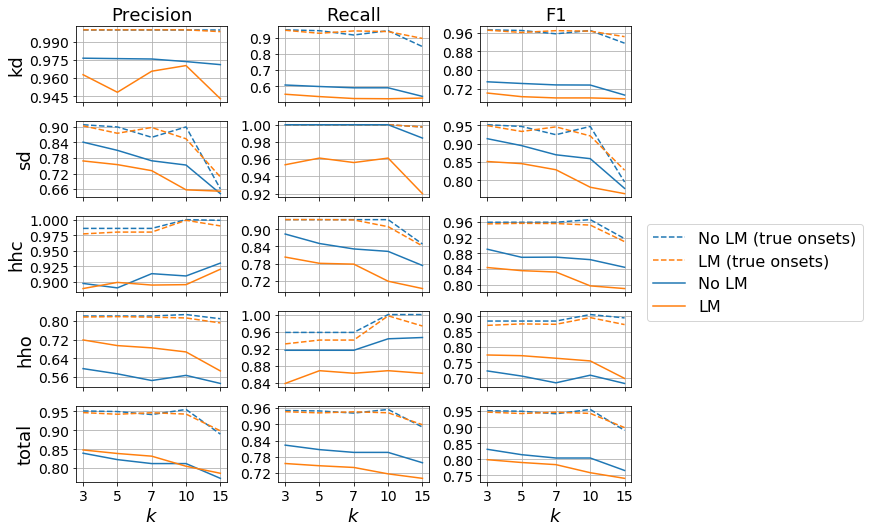

In [26]:
eval_series_nolm = vxs.metrics_series(evaluation_cfs, 'nolm')
eval_series_lm = vxs.metrics_series(evaluation_cfs, 'lm')
#plot_all_metrics(eval_series_lm, eval_series_nolm, save_name='lm_nolm_avpfixed_gen')

eval_series_noonsets_nolm = vxs.metrics_series(evaluation_cfs_noonsets, 'nolm')
eval_series_noonsets_lm = vxs.metrics_series(evaluation_cfs_noonsets, 'lm')
#plot_all_metrics(eval_series_noonsets_lm, eval_series_noonsets_nolm, save_name='lm_nolm_avpfixed_gen_noonsets')

plot_all_metrics(eval_series_lm, eval_series_nolm,
                 eval_series_noonsets_lm, eval_series_noonsets_nolm,
                 save_name='lm_nolm_avpfixed_gen', fsize=18, fsize_mul=(3, 1.5))

In [59]:
evaluation_cfs_noonsets[10]['nolm']

hhc    hho     kd     sd  sil
hhc  944.0    0.0    0.0  109.0  0.0
hho  127.0  208.0    0.0    0.0  0.0
kd     0.0    0.0  754.0    0.0  0.0
sd    10.0    0.0   52.0  325.0  0.0
sil    0.0    0.0    0.0    0.0  0.0

In [58]:
evaluation_cfs_noonsets[10]['lm']

hhc    hho     kd     sd  sil
hhc  945.0    2.0    0.0  106.0  0.0
hho  133.0  202.0    0.0    0.0  0.0
kd     0.0    0.0  754.0    0.0  0.0
sd     7.0    0.0   50.0  330.0  0.0
sil    0.0    0.0    0.0    0.0  0.0

In [18]:
paths = glob.glob('../data_temp/avp-cut/personal/*/*.wav')
excluded_ps = [f'participant_{n}' for n in range(1, 6)]
paths = [p for p in paths if PurePath(p).parts[-2] not in excluded_ps]

avp_segments_personal_p6_28 = vxs.SimpleSampleSet(paths)
len(avp_segments_personal_p6_28)

2317

In [32]:
gen_set_p = vxs.GenTrackSet('../data_temp/avp-gen-personal/')
len(gen_set_p)

50

In [20]:
mfcc_classifier = vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance')
X, y = vxsu.unzip_dataset(avp_segments_personal_p6_28)
mfcc_classifier.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransform(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [33]:
evaluation_cfs_p = evaluate_with_different_k(
    gen_set_p, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avppersonal_k{}',
    predefined_bpm=True)

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 50it [00:12,  3.98it/s]


prec       rec        F1
hhc    0.778761  0.154657  0.258065
hho    0.108997  0.446809  0.175243
kd     0.413712  0.205399   0.27451
sd     0.190332  0.345205  0.245375
total  0.285866  0.216346  0.246294

Analysing tracks: 1it [00:00,  6.43it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.14it/s]


prec       rec        F1
hhc    0.812709  0.213533  0.338205
hho    0.140625  0.382979  0.205714
kd     0.422983  0.203052  0.274385
sd     0.171788  0.336986  0.227567
total  0.327987   0.23758  0.275558

Analysing tracks: 1it [00:00,  6.33it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.11it/s]


prec       rec        F1
hhc    0.778656  0.173111  0.283249
hho    0.150087  0.609929  0.240896
kd     0.411765  0.205399   0.27408
sd     0.197492  0.345205  0.251246
total  0.309158  0.233974  0.266363

Analysing tracks: 1it [00:00,  6.57it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.14it/s]


prec       rec        F1
hhc    0.860294  0.205624  0.331915
hho    0.124711  0.382979  0.188153
kd     0.416867  0.203052  0.273086
sd     0.194767  0.367123  0.254511
total  0.329093  0.238381  0.276487

Analysing tracks: 1it [00:00,  6.00it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.19it/s]


prec       rec        F1
hhc    0.777358  0.181019  0.293656
hho    0.147664  0.560284  0.233728
kd     0.415677  0.205399  0.274941
sd     0.188623  0.345205   0.24395
total  0.310217  0.234776  0.267275

Analysing tracks: 1it [00:00,  5.88it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.20it/s]


prec       rec        F1
hhc     0.82449  0.177504  0.292119
hho     0.12993  0.397163  0.195804
kd     0.434673  0.203052    0.2768
sd     0.196185  0.394521  0.262056
total  0.318031  0.230369  0.267193

Analysing tracks: 1it [00:00,  5.18it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.09it/s]


prec       rec        F1
hhc    0.836013  0.228471  0.358868
hho    0.170431  0.588652  0.264331
kd     0.433168  0.205399  0.278662
sd     0.209607  0.394521  0.273764
total   0.35045  0.265224  0.301938

Analysing tracks: 1it [00:00,  6.86it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.12it/s]


prec       rec        F1
hhc    0.911475  0.244288  0.385308
hho    0.170455  0.425532  0.243408
kd       0.4325  0.203052  0.276358
sd     0.198402  0.408219  0.267025
total  0.365044  0.264423  0.306691

Analysing tracks: 1it [00:00,  5.70it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.06it/s]


prec       rec        F1
hhc    0.861017  0.223199  0.354501
hho     0.17773  0.588652  0.273026
kd     0.404157  0.205399  0.272374
sd     0.174352  0.331507  0.228517
total  0.335098  0.253606  0.288712

Analysing tracks: 1it [00:00,  5.09it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.07it/s]


prec       rec        F1
hhc    0.908497  0.244288  0.385042
hho    0.164384  0.425532  0.237154
kd     0.449351  0.203052  0.279709
sd     0.204787  0.421918  0.275739
total   0.36781  0.266426  0.309015

In [34]:
evaluation_cfs_p_noonsets = evaluate_with_different_k(
    gen_set_p, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avppersonal_noonsets_k{}',
    predefined_bpm=True, predefined_onsets=True)

Analysing tracks: 1it [00:00,  5.94it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.98it/s]


prec       rec        F1
hhc     0.727794  0.223199  0.341627
hho    0.0848624  0.262411   0.12825
kd      0.669377  0.579812  0.621384
sd      0.143885  0.383562  0.209268
total   0.370593  0.370593  0.370593

Analysing tracks: 1it [00:00,  5.14it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.13it/s]


prec       rec        F1
hhc     0.761155  0.254833   0.38183
hho    0.0921986  0.276596  0.138298
kd      0.680441  0.579812  0.626109
sd      0.144928  0.383562  0.210368
total   0.385817  0.385817  0.385817

Analysing tracks: 1it [00:00,  6.59it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.06it/s]


prec       rec        F1
hhc     0.711538  0.195079  0.306207
hho    0.0878661  0.297872  0.135703
kd      0.669377  0.579812  0.621384
sd      0.144628  0.383562  0.210053
total   0.359776  0.359776  0.359776

Analysing tracks: 1it [00:00,  5.40it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.14it/s]


prec       rec        F1
hhc     0.743284  0.218805  0.338086
hho    0.0860215  0.283688  0.132013
kd      0.696756  0.579812  0.632928
sd      0.171226  0.463014      0.25
total    0.38141   0.38141   0.38141

Analysing tracks: 1it [00:00,  6.37it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.97it/s]


prec       rec        F1
hhc    0.721477  0.188928  0.299443
hho    0.100616  0.347518  0.156051
kd     0.669377  0.579812  0.621384
sd     0.143885  0.383562  0.209268
total  0.359776  0.359776  0.359776

Analysing tracks: 1it [00:00,  6.07it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.08it/s]


prec       rec        F1
hhc     0.706422  0.202988  0.315358
hho    0.0783505  0.269504  0.121406
kd       0.69774  0.579812  0.633333
sd      0.173156  0.463014  0.252051
total   0.373397  0.373397  0.373397

Analysing tracks: 1it [00:00,  5.99it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.11it/s]


prec       rec        F1
hhc    0.809117  0.249561  0.381464
hho    0.169533  0.489362  0.251825
kd     0.696756  0.579812  0.632928
sd     0.164237  0.463014  0.242468
total  0.407051  0.407051  0.407051

Analysing tracks: 1it [00:00,  5.55it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.09it/s]


prec       rec        F1
hhc    0.810474  0.285589  0.422352
hho    0.114355  0.333333   0.17029
kd     0.699717  0.579812  0.634146
sd     0.172802  0.463014  0.251675
total  0.414663  0.414663  0.414663

Analysing tracks: 1it [00:00,  5.22it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.10it/s]


prec       rec        F1
hhc    0.768977  0.204745  0.323387
hho    0.163895  0.489362  0.245552
kd     0.669377  0.579812  0.621384
sd     0.135397  0.383562  0.200143
total     0.375     0.375     0.375

Analysing tracks: 1it [00:00,  5.88it/s]

Evaluating (LM)


Analysing tracks: 50it [00:10,  4.90it/s]


prec       rec        F1
hhc    0.818991  0.242531  0.374237
hho    0.147583  0.411348  0.217228
kd     0.698727  0.579812   0.63374
sd      0.15864  0.460274  0.235955
total  0.399038  0.399038  0.399038

3: undetected onsets 680.0
5: undetected onsets 680.0
7: undetected onsets 680.0
10: undetected onsets 680.0
15: undetected onsets 680.0
3: undetected onsets 745.0
5: undetected onsets 745.0
7: undetected onsets 745.0
10: undetected onsets 745.0
15: undetected onsets 745.0
3: undetected onsets 0.0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0.0
3: undetected onsets 0.0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0.0


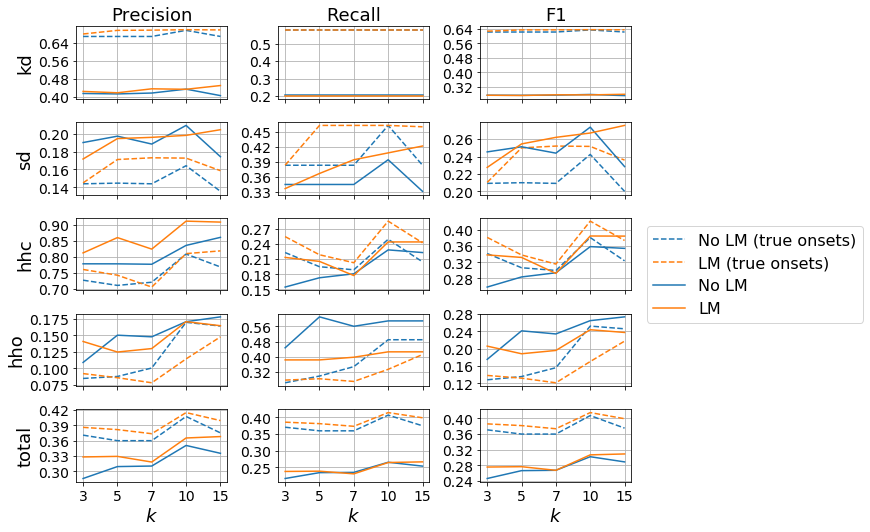

In [35]:
eval_series_p_nolm = vxs.metrics_series(evaluation_cfs_p, 'nolm')
eval_series_p_lm = vxs.metrics_series(evaluation_cfs_p, 'lm')

eval_series_p_noonsets_nolm = vxs.metrics_series(evaluation_cfs_p_noonsets, 'nolm')
eval_series_p_noonsets_lm = vxs.metrics_series(evaluation_cfs_p_noonsets, 'lm')

#plot_all_metrics(eval_series_p_lm, eval_series_p_nolm, save_name='lm_nolm_avppersonal_gen')
plot_all_metrics(eval_series_p_lm, eval_series_p_nolm,
                 eval_series_p_noonsets_lm, eval_series_p_noonsets_nolm,
                 save_name='lm_nolm_avppersonal_gen', fsize=18, fsize_mul=(3, 1.5))

## Professional beatboxers: classifying only with real drum machine sounds

In [51]:
drums200 = vxs.SimpleSampleSet.from_csv('../data/200-drum-machines/annotation.csv')
print(len(drums200))
bbx1_gen = vxs.GenTrackSet('../data_temp/beatboxset1-gen')
print(len(bbx1_gen))

1422
50


In [52]:
evaluation_cfs_bbx1 = vxs.evaluate_with_different_data_sizes(
    drums200, bbx1_gen, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_bbx1gen_p{}',
    predefined_bpm=True)

10% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:10,  4.57it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.317718  0.940934  0.475035
sd    0.73747   0.66167  0.697517

prec    0.263797
rec     0.400651
F1      0.293138
dtype: float64

Analysing tracks: 1it [00:00,  7.71it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.80it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.301065  0.892857  0.450294
sd   0.751899  0.635974  0.689095

prec    0.263241
rec     0.382208
F1      0.284847
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.34it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:08,  5.71it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370166   0.92033  0.527975
sd   0.410458  0.672377   0.50974

prec    0.195156
rec     0.398177
F1      0.259429
dtype: float64

Analysing tracks: 1it [00:00,  8.32it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.79it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.355033    0.891484    0.507825
sd   0.425414    0.659529    0.517212

prec    0.445112
rec     0.388172
F1      0.257095
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.11it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.49it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.335903  0.837912   0.47956
sd   0.412385  0.670236  0.510604

prec    0.187072
rec     0.377037
F1      0.247541
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.33it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.344699    0.888736    0.496737
sd   0.465976    0.674518    0.551181

prec    0.452669
rec     0.391023
F1      0.262398
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.30it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.357835  0.862637   0.50584
sd   0.382927  0.672377  0.487956

prec    0.185190
rec     0.383754
F1      0.248449
dtype: float64

Analysing tracks: 1it [00:00,  7.70it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.42it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.352454    0.877747    0.502952
sd   0.410014    0.648822    0.502488

prec    0.440617
rec     0.382061
F1      0.252195
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.35it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.341094  0.865385   0.48932
sd   0.431319  0.672377  0.525523

prec    0.193103
rec     0.384440
F1      0.253711
dtype: float64

Analysing tracks: 1it [00:00,  7.60it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.33it/s]


prec         rec          F1
hhc         1  0.00167364  0.00334169
hho         0           0           0
kd   0.341164    0.877747    0.491349
sd   0.440353    0.640257    0.521815

prec    0.445379
rec     0.379919
F1      0.254127
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.18it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.25it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd    0.33988  0.855769  0.486529
sd   0.419137  0.665953  0.514475

prec    0.189754
rec     0.380431
F1      0.250251
dtype: float64

Analysing tracks: 0it [00:00, ?it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.15it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.352681    0.876374    0.502956
sd   0.408602    0.650964    0.502064

prec    0.440321
rec     0.382044
F1      0.251673
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.22it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.20it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.341793  0.869505  0.490698
sd    0.42462  0.657388  0.515966

prec    0.191603
rec     0.381723
F1      0.251666
dtype: float64

Analysing tracks: 1it [00:00,  6.81it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.35it/s]


prec         rec          F1
hhc         1  0.00083682  0.00167224
hho         0           0           0
kd   0.344828    0.892857    0.497512
sd   0.450599     0.64454    0.530396

prec    0.448857
rec     0.384558
F1      0.257395
dtype: float64

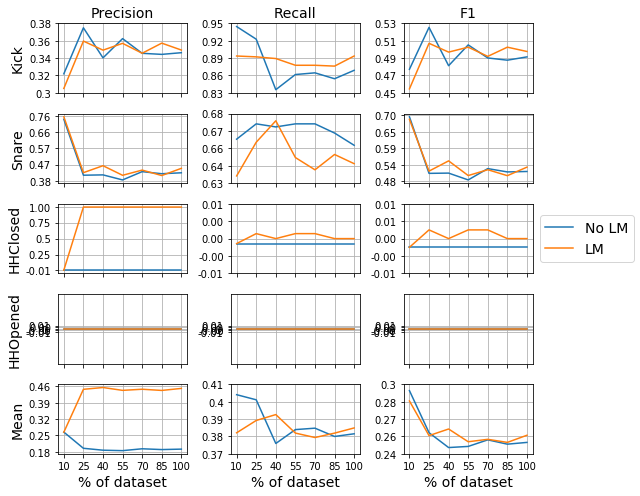

In [110]:
eval_series_bbx1_nolm = vxs.metrics_series(evaluation_cfs_bbx1, 'nolm')
eval_series_bbx1_lm = vxs.metrics_series(evaluation_cfs_bbx1, 'lm')
plot_all_metrics(eval_series_bbx1_lm, eval_series_bbx1_nolm)

In [54]:
evaluation_cfs_bbx1_noonsets = vxs.evaluate_with_different_data_sizes(
    drums200, bbx1_gen, lang_model,
    model_fn=lambda: vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance'),
    savedir_pattern='../logs/lm_eval/comparison_lm_mfcc_bbx1gen_noonsets_p{}',
    predefined_bpm=True, predefined_onsets=True)

10% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.08it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.44it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.397814         1  0.569195
sd   0.480597  0.689507  0.566403

prec    0.219603
rec     0.422377
F1      0.283899
dtype: float64

Analysing tracks: 1it [00:00,  8.42it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.61it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.362031  0.901099  0.516535
sd   0.415698   0.61242  0.495238

prec    0.194432
rec     0.378380
F1      0.252943
dtype: float64

25% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.37it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.405688  0.960165  0.570379
sd   0.378378   0.62955  0.472669

prec    0.196017
rec     0.397429
F1      0.260762
dtype: float64

Analysing tracks: 1it [00:00,  7.10it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.51it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.381473  0.910714  0.537713
sd   0.388451  0.633833  0.481692

prec    0.192481
rec     0.386137
F1      0.254851
dtype: float64

40% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.22it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.53it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370857  0.891484   0.52381
sd      0.392   0.62955  0.483155

prec    0.190714
rec     0.380258
F1      0.251741
dtype: float64

Analysing tracks: 1it [00:00,  7.14it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.58it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371396  0.902473  0.526231
sd   0.409029  0.640257  0.499165

prec    0.195106
rec     0.385682
F1      0.256349
dtype: float64

55% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.15it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.42it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.387001  0.891484  0.539709
sd    0.35723   0.62955  0.455814

prec    0.186058
rec     0.380258
F1      0.248881
dtype: float64

Analysing tracks: 1it [00:00,  6.97it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.58it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.378063   0.89011  0.530713
sd   0.368957  0.620985  0.462889

prec    0.186755
rec     0.377774
F1      0.248400
dtype: float64

70% of dataset
Classifier training...


Analysing tracks: 0it [00:00, ?it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.31it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.373418  0.891484  0.526358
sd   0.410761  0.670236  0.509357

prec    0.196045
rec     0.390430
F1      0.258929
dtype: float64

Analysing tracks: 1it [00:00,  7.29it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.51it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371221  0.910714  0.527446
sd   0.403361  0.616702  0.487722

prec    0.193645
rec     0.381854
F1      0.253792
dtype: float64

85% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.15it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.31it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.370434  0.891484  0.523387
sd   0.393048   0.62955  0.483951

prec    0.190870
rec     0.380258
F1      0.251834
dtype: float64

Analysing tracks: 1it [00:00,  7.08it/s]

Evaluating (LM)


Analysing tracks: 50it [00:08,  5.59it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.379754  0.891484  0.532622
sd   0.370417  0.627409  0.465819

prec    0.187543
rec     0.379723
F1      0.249610
dtype: float64

100% of dataset
Classifier training...


Analysing tracks: 1it [00:00,  5.09it/s]

Evaluating (no LM)


Analysing tracks: 50it [00:09,  5.43it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.371023  0.896978   0.52492
sd   0.397297   0.62955  0.487158

prec    0.192080
rec     0.381632
F1      0.253019
dtype: float64

Analysing tracks: 1it [00:00,  7.23it/s]

Evaluating (LM)


Analysing tracks: 50it [00:09,  5.48it/s]


prec       rec        F1
hhc         0         0         0
hho         0         0         0
kd   0.374068  0.895604  0.527722
sd   0.380449  0.616702  0.470588

prec    0.188629
rec     0.378077
F1      0.249577
dtype: float64

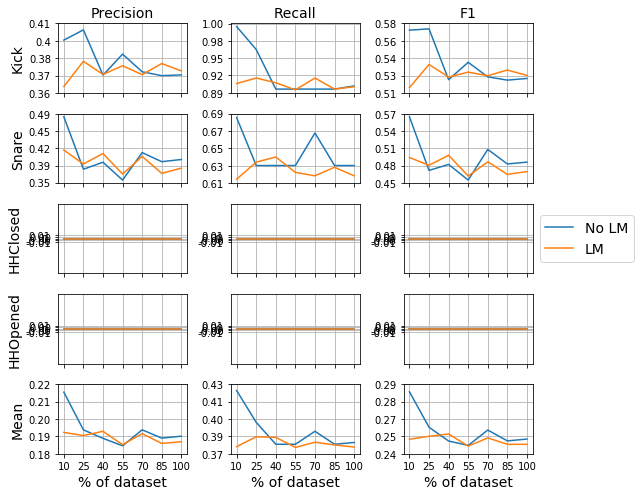

In [111]:
eval_series_bbx1_noonsets_nolm = vxs.metrics_series(evaluation_cfs_bbx1_noonsets, 'nolm')
eval_series_bbx1_noonsets_lm = vxs.metrics_series(evaluation_cfs_bbx1_noonsets, 'lm')
plot_all_metrics(eval_series_bbx1_noonsets_lm, eval_series_bbx1_noonsets_nolm)

### Real data: classifying AVP dataset (fixed)

In [10]:
avp_improv_fixed = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Fixed', recordings_type='improvs')
len(avp_improv_fixed)

28

In [11]:
avp_hits_fixed = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/fixed/*/*.wav'))
len(avp_hits_fixed)

3317

In [12]:
mfcc_classifier = vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance')
X, y = vxsu.unzip_dataset(avp_hits_fixed)
mfcc_classifier.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransform(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [15]:
evaluation_cfs_avpfixed_real = evaluate_with_different_k(
    avp_improv_fixed, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avpfixed_real_k{}')

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 28it [00:05,  5.27it/s]


prec       rec        F1
hhc    0.613889  0.717532  0.661677
hho        0.78  0.745902   0.76257
kd     0.882012  0.835165  0.857949
sd     0.801587  0.830137  0.815612
total  0.780685  0.790536   0.78558

Analysing tracks: 3it [00:00, 19.32it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 16.92it/s]


prec       rec        F1
hhc     0.59726  0.707792  0.647845
hho    0.807692  0.688525  0.743363
kd     0.910569  0.820513  0.863198
sd     0.788043  0.794521  0.791269
total  0.785947  0.762145  0.773863

Analysing tracks: 3it [00:00, 19.17it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.32it/s]


prec       rec        F1
hhc    0.621622  0.746753  0.678466
hho     0.78187  0.754098  0.767733
kd     0.901575  0.838828   0.86907
sd     0.823529  0.843836  0.833559
total  0.792523  0.802524  0.797492

Analysing tracks: 3it [00:00, 18.56it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 16.95it/s]


prec       rec        F1
hhc    0.614555   0.74026  0.671576
hho    0.810127  0.699454  0.750733
kd     0.908537  0.818681  0.861272
sd     0.815642       0.8  0.807746
total  0.795706  0.771609  0.783472

Analysing tracks: 3it [00:00, 19.30it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.58it/s]


prec       rec        F1
hhc    0.617801  0.766234  0.684058
hho    0.789174  0.756831  0.772664
kd     0.898039  0.838828  0.867424
sd     0.839779  0.832877  0.836314
total  0.794393  0.804416  0.799373

Analysing tracks: 2it [00:00, 19.39it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.20it/s]


prec       rec        F1
hhc    0.587654  0.772727  0.667602
hho     0.82069  0.650273   0.72561
kd     0.911469   0.82967  0.868648
sd     0.828986  0.783562  0.805634
total  0.790501  0.766562  0.778347

Analysing tracks: 3it [00:00, 19.31it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.04it/s]


prec       rec        F1
hhc    0.628947  0.775974  0.694767
hho    0.789326   0.76776  0.778393
kd     0.896887  0.844322  0.869811
sd     0.853521  0.830137  0.841667
total       0.8  0.810095  0.805016

Analysing tracks: 2it [00:00, 18.77it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 15.40it/s]


prec       rec        F1
hhc    0.587629   0.74026  0.655172
hho    0.819113  0.655738  0.728376
kd        0.902  0.826007  0.862333
sd     0.814607  0.794521  0.804438
total  0.786597  0.762776  0.774504

Analysing tracks: 3it [00:00, 18.30it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.32it/s]


prec       rec        F1
hhc    0.634465  0.788961  0.703329
hho    0.796703   0.79235  0.794521
kd     0.900778  0.847985  0.873585
sd     0.869186  0.819178  0.843441
total  0.806854  0.817035  0.811912

Analysing tracks: 2it [00:00, 17.95it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.02it/s]


prec       rec        F1
hhc    0.571072  0.743506   0.64598
hho    0.821053  0.639344  0.718894
kd     0.913481  0.831502  0.870566
sd      0.80226  0.778082  0.789986
total  0.781392  0.757729  0.769379

In [16]:
evaluation_cfs_avpfixed_real_noonsets = evaluate_with_different_k(
    avp_improv_fixed, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avpfixed_real_noonsets_k{}', predefined_onsets=True)

Analysing tracks: 2it [00:00, 15.69it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 28it [00:01, 16.84it/s]


prec       rec        F1
hhc    0.660274  0.782468  0.716196
hho    0.835404  0.734973  0.781977
kd     0.967308  0.921245  0.943715
sd     0.848901  0.846575  0.847737
total  0.841502  0.834069  0.837769

Analysing tracks: 2it [00:00, 16.27it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.41it/s]


prec       rec        F1
hhc    0.674931  0.795455  0.730253
hho    0.881944  0.693989  0.776758
kd     0.958254  0.924908  0.941286
sd     0.885246  0.887671  0.886457
total  0.860104  0.837855  0.848833

Analysing tracks: 3it [00:00, 18.95it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.01it/s]


prec       rec        F1
hhc    0.716332  0.811688  0.761035
hho    0.868902  0.778689  0.821326
kd     0.977143   0.93956  0.957983
sd     0.879896  0.923288   0.90107
total  0.873817  0.873817  0.873817

Analysing tracks: 2it [00:00, 16.10it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.16it/s]


prec       rec        F1
hhc    0.685637  0.821429  0.747415
hho    0.891986  0.699454  0.784074
kd     0.960076  0.924908  0.942164
sd     0.906077   0.89863  0.902338
total  0.869171  0.846688  0.857782

Analysing tracks: 3it [00:00, 19.16it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 28it [00:01, 18.00it/s]


prec       rec        F1
hhc    0.723164  0.831169  0.773414
hho    0.873846  0.775956  0.821997
kd      0.97723  0.943223  0.959925
sd     0.894459  0.928767   0.91129
total  0.879495  0.879495  0.879495

Analysing tracks: 2it [00:00, 19.61it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.47it/s]


prec       rec        F1
hhc    0.685333  0.834416  0.752562
hho         0.9  0.688525  0.780186
kd     0.963462  0.917582  0.939962
sd     0.899729  0.909589  0.904632
total  0.869171  0.846688  0.857782

Analysing tracks: 3it [00:00, 20.15it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.98it/s]


prec       rec        F1
hhc    0.725212  0.831169  0.774584
hho    0.870091  0.786885  0.826399
kd     0.977143   0.93956  0.957983
sd     0.896277  0.923288  0.909582
total  0.879495  0.879495  0.879495

Analysing tracks: 3it [00:00, 19.29it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.66it/s]


prec       rec        F1
hhc    0.693767  0.831169  0.756278
hho     0.87931  0.696721  0.777439
kd     0.961977   0.92674   0.94403
sd     0.924791  0.909589  0.917127
total  0.873705  0.851104  0.862256

Analysing tracks: 3it [00:00, 19.28it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 28it [00:01, 17.66it/s]


prec       rec        F1
hhc     0.73743  0.857143  0.792793
hho    0.886228  0.808743  0.845714
kd     0.975564  0.950549  0.962894
sd     0.919668  0.909589  0.914601
total  0.890221  0.890221  0.890221

Analysing tracks: 3it [00:00, 18.10it/s]

Evaluating (LM)


Analysing tracks: 28it [00:01, 17.17it/s]


prec       rec        F1
hhc     0.67979  0.840909  0.751814
hho    0.905109  0.677596     0.775
kd     0.962121  0.930403  0.945996
sd     0.916898  0.906849  0.911846
total  0.871762  0.849211  0.860339

onsets
3: undetected onsets 89.0
5: undetected onsets 89.0
7: undetected onsets 89.0
10: undetected onsets 89.0
15: undetected onsets 89.0
3: undetected onsets 144.0
5: undetected onsets 144.0
7: undetected onsets 144.0
10: undetected onsets 144.0
15: undetected onsets 144.0
noonsets
3: undetected onsets 16.0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0.0
3: undetected onsets 41.0
5: undetected onsets 41.0
7: undetected onsets 41.0
10: undetected onsets 41.0
15: undetected onsets 41.0


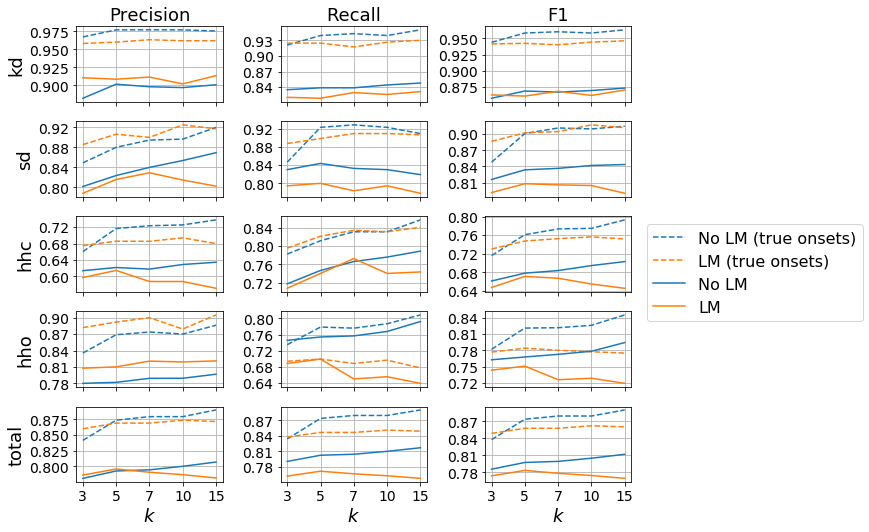

In [22]:
print('onsets')
eval_series_avpfixed_real_nolm = vxs.metrics_series(evaluation_cfs_avpfixed_real, 'nolm')
eval_series_avpfixed_real_lm = vxs.metrics_series(evaluation_cfs_avpfixed_real, 'lm')
print('noonsets')
eval_series_avpfixed_real_noonsets_nolm = vxs.metrics_series(evaluation_cfs_avpfixed_real_noonsets, 'nolm')
eval_series_avpfixed_real_noonsets_lm = vxs.metrics_series(evaluation_cfs_avpfixed_real_noonsets, 'lm')

plot_all_metrics(eval_series_avpfixed_real_lm, eval_series_avpfixed_real_nolm,
                 eval_series_avpfixed_real_noonsets_lm, eval_series_avpfixed_real_noonsets_nolm,
                 save_name='lm_nolm_avpfixed_real', fsize=18, fsize_mul=(3, 1.5))

### Real data: AVP Personal

In [24]:
avp_improv_personal = vxs.AVPTrackSet('../data/avp-dataset/AVP_Dataset/', subset='Personal', recordings_type='improvs')
len(avp_improv_personal)

25

In [25]:
avp_hits_personal = vxs.SimpleSampleSet(glob.glob('../data_temp/avp-cut/personal/*/*.wav'))
len(avp_hits_personal)

2875

In [38]:
mfcc_classifier = vxs.make_knn_classic('mfcc', n_neighbors=3, weights='distance')
X, y = vxsu.unzip_dataset(avp_hits_personal)
mfcc_classifier.fit(X, y)

Pipeline(steps=[('features', ClassicFeatureTransform(feature_type='mfcc')),
                ('normalizer', Normalizer()),
                ('classifier',
                 KNeighborsClassifier(n_neighbors=3, weights='distance'))])

In [26]:
evaluation_cfs_avppersonal_real = evaluate_with_different_k(
    avp_improv_personal, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avppersonal_real_k{}')

Analysing tracks: 0it [00:00, ?it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 25it [00:04,  5.33it/s]


prec       rec        F1
hhc    0.496795  0.476923  0.486656
hho    0.308725  0.531792  0.390658
kd      0.69697  0.857904  0.769108
sd     0.678445  0.509284  0.581818
total  0.581337  0.641168  0.609788

Analysing tracks: 2it [00:00, 19.36it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 16.11it/s]


prec       rec        F1
hhc    0.536585  0.475309  0.504092
hho    0.332117  0.526012  0.407159
kd     0.707101  0.849023   0.77159
sd     0.666667  0.458667  0.543444
total  0.598662  0.623693  0.610922

Analysing tracks: 3it [00:00, 18.67it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 25it [00:01, 16.83it/s]


prec       rec        F1
hhc    0.514377  0.495385  0.504702
hho    0.336601  0.595376  0.430063
kd     0.699422   0.85968  0.771315
sd     0.694545  0.506631   0.58589
total  0.592055   0.65299  0.621032

Analysing tracks: 3it [00:00, 19.04it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.31it/s]


prec       rec        F1
hhc    0.523659  0.512346  0.517941
hho     0.32197  0.491329  0.389016
kd     0.698957  0.833037   0.76013
sd     0.707819  0.458667  0.556634
total  0.596656  0.621603  0.608874

Analysing tracks: 3it [00:00, 19.22it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 25it [00:01, 16.91it/s]


prec       rec        F1
hhc    0.526316  0.523077  0.524691
hho    0.328947  0.578035  0.419287
kd     0.707246  0.866785  0.778931
sd     0.732342  0.522546  0.609907
total  0.602144  0.664117  0.631614

Analysing tracks: 3it [00:00, 19.90it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 16.60it/s]


prec       rec        F1
hhc    0.520958  0.537037  0.528875
hho    0.327586  0.439306  0.375309
kd     0.699413  0.847247  0.766265
sd     0.692308     0.456  0.549839
total  0.600669  0.625784  0.612969

Analysing tracks: 3it [00:00, 17.84it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 25it [00:01, 16.59it/s]


prec       rec        F1
hhc     0.51506  0.526154  0.520548
hho    0.312292  0.543353  0.396624
kd     0.704776  0.865009  0.776715
sd     0.740458  0.513228   0.60625
total  0.596469  0.657401  0.625455

Analysing tracks: 3it [00:00, 18.98it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.13it/s]


prec       rec        F1
hhc    0.515493  0.564815  0.539028
hho    0.352679  0.456647  0.397985
kd     0.702823  0.840142  0.765372
sd     0.695473  0.450667  0.546926
total  0.604682  0.629965  0.617065

Analysing tracks: 3it [00:00, 19.59it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 25it [00:01, 16.70it/s]


prec       rec        F1
hhc    0.498516  0.516923  0.507553
hho    0.307443  0.549133  0.394191
kd     0.703013  0.870337  0.777778
sd     0.740741   0.47619   0.57971
total  0.588272  0.648367   0.61686

Analysing tracks: 3it [00:00, 19.35it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.00it/s]


prec       rec        F1
hhc    0.485411  0.564815  0.522111
hho    0.330233  0.410405  0.365979
kd     0.699102  0.829485  0.758733
sd     0.680851  0.426667   0.52459
total  0.589298  0.613937  0.601365

In [27]:
evaluation_cfs_avppersonal_real_noonsets = evaluate_with_different_k(
    avp_improv_personal, mfcc_classifier, lang_model,
    savedir_pattern='../logs/lm_eval/comparison_backtrack_lm_mfcc_avppersonal_real_noonsets_k{}', predefined_onsets=True)

Analysing tracks: 3it [00:00, 19.22it/s]

k-NN with k = 3
Evaluating (no LM)


Analysing tracks: 25it [00:01, 17.75it/s]


prec       rec        F1
hhc     0.55102  0.501548  0.525122
hho    0.353147  0.583815  0.440087
kd     0.853535  0.900533  0.876404
sd     0.725869  0.502674  0.593997
total  0.668528  0.668528  0.668528

Analysing tracks: 3it [00:00, 19.45it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.47it/s]


prec       rec        F1
hhc    0.549153  0.501548  0.524272
hho    0.363296  0.560694  0.440909
kd      0.84048  0.870337  0.855148
sd     0.761702   0.47861  0.587849
total  0.672464  0.647592  0.659794

Analysing tracks: 3it [00:00, 19.33it/s]

k-NN with k = 5
Evaluating (no LM)


Analysing tracks: 25it [00:01, 17.78it/s]


prec       rec        F1
hhc    0.549342  0.517028  0.532695
hho    0.359431  0.583815  0.444934
kd     0.859766  0.914742  0.886403
sd     0.771084  0.513369  0.616372
total  0.680391  0.680391  0.680391

Analysing tracks: 2it [00:00, 17.42it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.63it/s]


prec       rec        F1
hhc    0.532258  0.510836  0.521327
hho    0.370079  0.543353  0.440281
kd     0.826377  0.879218  0.851979
sd     0.774194  0.449198  0.568528
total  0.668116  0.643405  0.655528

Analysing tracks: 3it [00:00, 19.38it/s]

k-NN with k = 7
Evaluating (no LM)


Analysing tracks: 25it [00:01, 16.25it/s]


prec       rec        F1
hhc    0.556962  0.544892  0.550861
hho    0.348921  0.560694  0.430155
kd     0.863866  0.912966  0.887737
sd     0.782787  0.510695  0.618123
total  0.682484  0.682484  0.682484

Analysing tracks: 3it [00:00, 19.29it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.66it/s]


prec       rec        F1
hhc    0.523529  0.551084  0.536953
hho     0.29918  0.421965   0.35012
kd     0.832487   0.87389  0.852686
sd      0.77561  0.425134  0.549223
total  0.653623  0.629449  0.641308

Analysing tracks: 3it [00:00, 18.26it/s]

k-NN with k = 10
Evaluating (no LM)


Analysing tracks: 25it [00:01, 17.56it/s]


prec       rec        F1
hhc    0.565916  0.544892  0.555205
hho    0.346715  0.549133  0.425056
kd     0.870152  0.916519  0.892734
sd     0.764706   0.52139  0.620032
total  0.685276  0.685276  0.685276

Analysing tracks: 3it [00:00, 19.80it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.54it/s]


prec       rec        F1
hhc    0.502874  0.541796   0.52161
hho    0.323276  0.433526   0.37037
kd     0.826087  0.877442  0.850991
sd     0.782178   0.42246  0.548611
total  0.653623  0.629449  0.641308

Analysing tracks: 3it [00:00, 19.80it/s]

k-NN with k = 15
Evaluating (no LM)


Analysing tracks: 25it [00:01, 17.14it/s]


prec       rec        F1
hhc    0.550314  0.541796  0.546022
hho    0.341727  0.549133  0.421286
kd     0.869128  0.920071  0.893874
sd     0.763485  0.491979  0.598374
total  0.678297  0.678297  0.678297

Analysing tracks: 3it [00:00, 20.11it/s]

Evaluating (LM)


Analysing tracks: 25it [00:01, 17.84it/s]


prec       rec        F1
hhc     0.54386  0.575851  0.559398
hho    0.321739  0.427746  0.367246
kd     0.822076  0.886323  0.852991
sd     0.771144  0.414439   0.53913
total  0.662319  0.637823   0.64984

3: undetected onsets 31
5: undetected onsets 31
7: undetected onsets 31
10: undetected onsets 31
15: undetected onsets 31
3: undetected onsets 106.0
5: undetected onsets 106.0
7: undetected onsets 106.0
10: undetected onsets 106.0
15: undetected onsets 106.0
3: undetected onsets 0
5: undetected onsets 0.0
7: undetected onsets 0.0
10: undetected onsets 0.0
15: undetected onsets 0
3: undetected onsets 53.0
5: undetected onsets 53.0
7: undetected onsets 53.0
10: undetected onsets 53.0
15: undetected onsets 53.0


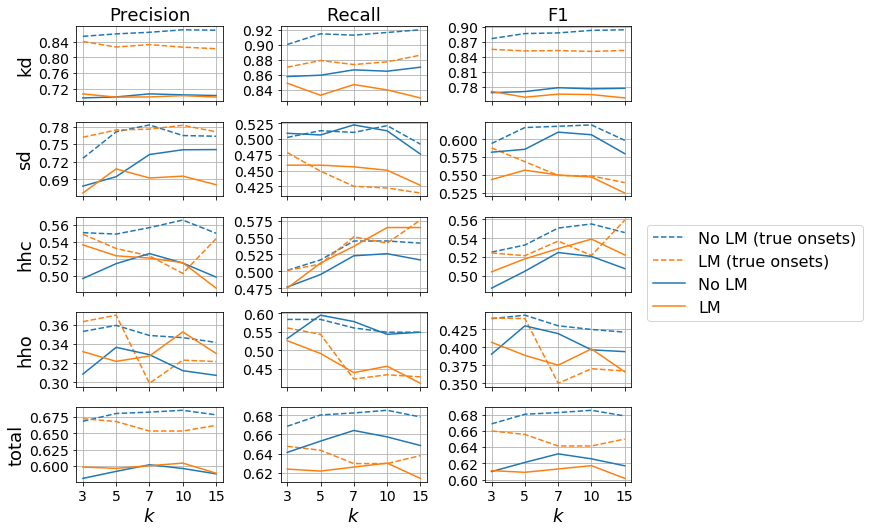

In [28]:
eval_series_avppersonal_real_nolm = vxs.metrics_series(evaluation_cfs_avppersonal_real, 'nolm')
eval_series_avppersonal_real_lm = vxs.metrics_series(evaluation_cfs_avppersonal_real, 'lm')
eval_series_avppersonal_real_noonsets_nolm = vxs.metrics_series(evaluation_cfs_avppersonal_real_noonsets, 'nolm')
eval_series_avppersonal_real_noonsets_lm = vxs.metrics_series(evaluation_cfs_avppersonal_real_noonsets, 'lm')

plot_all_metrics(eval_series_avppersonal_real_lm, eval_series_avppersonal_real_nolm,
                 eval_series_avppersonal_real_noonsets_lm, eval_series_avppersonal_real_noonsets_nolm,
                 save_name='lm_nolm_avppersonal_real', fsize=18, fsize_mul=(3, 1.5))